### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import qiskit
from qiskit_aer import AerSimulator
from qiskit import transpile, assemble
from qiskit.visualization import *

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# Get the datasets and reduce it
mask1 = list(i for i in range(0,5000))
mask2 = list(i for i in range(0,200))

train_dataset_full = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
train_dataset = torch.utils.data.Subset(train_dataset_full,mask1)
test_dataset_full = datasets.MNIST(root='./data',
                           train=False, 
                           transform=transforms.ToTensor())
test_dataset = torch.utils.data.Subset(test_dataset_full,mask2)

In [3]:
# Make the dataloaders
batch_size = 500
# n_iters = 1000
# num_epochs = n_iters / (len(train_dataset) / batch_size)
# num_epochs = int(num_epochs)
num_epochs = 50
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_full, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)
test_loader_full = torch.utils.data.DataLoader(dataset=test_dataset_full, 
                                          batch_size=batch_size, 
                                          shuffle=True)                                                

### Build Quantum circuits

In [4]:
class NewQuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        self._circuit.measure_all()
        # ---------------------------
        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        t_qc = transpile(self._circuit,
                            self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        expectlist = []
        for dictionary in list(result):
            if '1' in dictionary.keys():
                expectlist.append(dictionary['1']/self.shots)
            else:
                expectlist.append(0.0)
        return np.array(expectlist)
        # # print(job.result().data())
        # # counts = np.array(list(result.values() for result in results))
        # counts = np.array(list(result.values()))
        # # print(counts)
        # states = np.array(list(result.keys())).astype(float)
        # # print(states)
        # # Compute probabilities for each state
        # probabilities = counts / self.shots
        # # Get state expectation
        # expectation = np.sum(states * probabilities)
        # return np.array([expectation])

In [5]:
simulator = qiskit.Aer.get_backend('aer_simulator',method='matrix_product_state')

circuit = NewQuantumCircuit(1, simulator, 10)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi,np.pi/2])))
circuit._circuit.draw()

Expected value for rotation pi [0.4 1. ]


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [6]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = []
        for thetas in input:
            res = ctx.quantum_circuit.run(thetas.tolist())
            expectation_z.append(res)
        # expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        resultnp = np.array(expectation_z)
        result = torch.tensor(resultnp)
        ctx.save_for_backward(input, result)
        return result

        # inputnp = np.array(input)
        # ctx.save_for_backward(input)
        # result = torch.tensor((np.sin(np.pi/4 + inputnp/2.0))**2)
        # return result
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        gradients = []
        for thetas in input:
            shift_right = thetas.tolist() + np.ones(thetas.shape) * ctx.shift
            shift_left = thetas.tolist() - np.ones(thetas.shape) * ctx.shift

            exp_right = ctx.quantum_circuit.run(shift_right)
            exp_left = ctx.quantum_circuit.run(shift_left)
            gradients.append(exp_right-exp_left)
        gradnp = np.array(gradients)
        return torch.tensor(gradnp).float() * grad_output.float(), None, None

        # input = ctx.saved_tensors
        # inputnp = np.array(input)
        # grad = torch.tensor(np.sin(np.pi/2 + inputnp))
        # return grad*grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = NewQuantumCircuit(1, backend, shots)
        self.shift = shift
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [7]:
# The model to be used for training
channels = [1,16,32] #editable
channels.append(512*(channels[2]//32)) #Do not edit
channels += [256,10] #editable

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        # self.cnn1 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=5)
        self.relu = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Dropout
        self.dropout = nn.Dropout2d()

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        # self.cnn2 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=5)
        # self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Linear 1
        self.fc1 = nn.Linear(32*7*7, 256)
        # self.fc1 = nn.Linear(channels[3],channels[4])

        # Linear 2
        self.fc2 = nn.Linear(256, 10)
        # self.fc2 = nn.Linear(channels[4],channels[5])

        # Quantum out
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator', method='matrix_product_state'), 1000, 0.1)

        # Tanh
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.tanh(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        out = self.cnn2(out)
        out = self.tanh(out)

        # Max pool 2 
        out = self.maxpool2(out)
        # print(out.shape)

        # Dropout
        out = self.dropout(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        # out = out.view(-1, 8*4*4)
        out = out.view(out.size(0), -1)
        # print(out.shape)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        # Quantum out
        # print(out.shape)
        out = (np.pi/2) * self.tanh(out)
        out = self.hybrid(out)
        # print(out.shape)
        return out

### Train

In [10]:
model = CNNModel()
lossfn = nn.CrossEntropyLoss()

# learning_rate = 0.1
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# scheduler = torch.optim.ExponentialLR(optimizer, gamma=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=5, verbose=True
)

In [11]:
iter = 0
loss_list = []
for epoch in range(num_epochs):
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        # Load images
        images = images.requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)
        # print(outputs)

        # Calculate Loss: softmax --> cross entropy loss
        loss = lossfn(outputs, labels)
        losses.append(loss.item())

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 10 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images
                images = images.requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()

                # if accuracy > 90:
                #     learning_rate /= 10
                #     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            accuracy = 100 * correct / total
            


            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            model.train()
    mean_loss = sum(losses) / len(losses)
    loss_list.append(mean_loss)
    scheduler.step(mean_loss)


Iteration: 10. Loss: 2.0608282205857664. Accuracy: 76.0
Iteration: 20. Loss: 1.7832054565048372. Accuracy: 83.0
Iteration: 30. Loss: 1.688515861838918. Accuracy: 84.0
Iteration: 40. Loss: 1.6183117246817287. Accuracy: 90.0
Iteration: 50. Loss: 1.6050047038743778. Accuracy: 89.5
Iteration: 60. Loss: 1.5831725278377855. Accuracy: 92.0
Iteration: 70. Loss: 1.5771767968286552. Accuracy: 93.5
Iteration: 80. Loss: 1.5775882378111301. Accuracy: 93.5
Iteration: 90. Loss: 1.5577260457677247. Accuracy: 95.5
Iteration: 100. Loss: 1.5683525395534479. Accuracy: 95.5
Iteration: 110. Loss: 1.5339572065182012. Accuracy: 96.0
Iteration: 120. Loss: 1.5517861908459494. Accuracy: 95.0
Iteration: 130. Loss: 1.5339886829538616. Accuracy: 96.5
Iteration: 140. Loss: 1.5442980712032346. Accuracy: 97.5
Iteration: 150. Loss: 1.534608617709038. Accuracy: 97.0
Iteration: 160. Loss: 1.5237823593932265. Accuracy: 97.0
Iteration: 170. Loss: 1.5220372665101425. Accuracy: 99.5
Iteration: 180. Loss: 1.5256764933638303. 

In [ ]:
torch.save(model.state_dict(), "./modelstate.pth")

Text(0, 0.5, 'Neg Log Likelihood Loss')

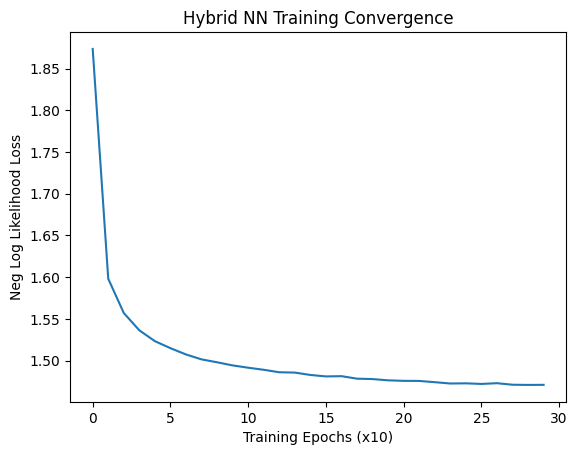

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Epochs (x10)')
plt.ylabel('Neg Log Likelihood Loss')

### Evaluate model

In [11]:
# Import the model if pre-trained
model = CNNModel()
lossfn = nn.CrossEntropyLoss()
model.load_state_dict(torch.load("./models/Best974_Batch100_QNN.pth"))

<All keys matched successfully>

In [14]:
model.eval()
# Calculate Accuracy         
correct = 0
total = 0
# Iterate through test dataset
for images, labels in test_loader_full:
    # Load images
    images = images.requires_grad_()

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    # Total number of labels
    total += labels.size(0)

    # Total correct predictions
    correct += (predicted == labels).sum()

accuracy = 100 * correct / total

# Print Loss
print(f'Accuracy is : {accuracy}')

Accuracy: 99.0


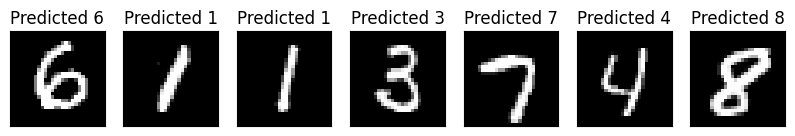

In [23]:
n_samples_show = 7
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for data, target in train_loader:
        if count == n_samples_show:
            break
        output = model(data[:4])
        
        _, predicted = torch.max(output.data, 1)
        # print(predicted)
        axes[count].imshow(data[3][0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(predicted[3].item()))
        
        count += 1